In [1]:
from typing import Optional

import numpy as np
import pandas as pd

In [3]:
def simulate_covariance_matrix(n: int, shrinkage: Optional[float] = None) -> np.ndarray:
    """
    Generates a random positive semi-definite covariance matrix of size n x n.
    
    If the optional `shrinkage` parameter is provided, the function applies a shrinkage 
    transformation to regularize the matrix. Shrinkage blends the covariance matrix 
    with a scaled identity matrix, which can help ensure positive semi-definiteness 
    and improve numerical stability in certain applications.

    Args:
        n (int): The size of the covariance matrix to generate.
        shrinkage (Optional[float]): A value between 0 and 1 controlling the degree of shrinkage applied to the covariance matrix.
            - If `shrinkage` is 0, no shrinkage is applied.
            - If `shrinkage` is 1, the covariance matrix is replaced by a diagonal matrix scaled by its variances.
            - If `shrinkage` is None, no shrinkage is applied unless the matrix is not positive semi-definite.

    Returns:
        np.ndarray: An n x n positive semi-definite covariance matrix.
    
    Raises:
        AssertionError: If `shrinkage` is provided and is not in the range [0, 1].
    """

    # Generate a random matrix
    A = np.random.randn(n, n)
    
    # Construct a positive semi-definite matrix - A' * A ensures positive semi-definiteness
    covariance_matrix = np.dot(np.transpose(A), A)

    # Regularize/shrink if the matrix is not positive semi-definite
    if shrinkage is not None or not all(np.linalg.eigvals(covariance_matrix) >= 0):

        assert 0 <= shrinkage <= 1

        # Lambda * Cov + (1 - Lambda) * I * Diagonal(Cov)
        covariance_matrix = (1  - shrinkage) * covariance_matrix + shrinkage * np.multiply(np.diag(covariance_matrix), np.identity(n=n))
    
    # Normalize diagonal entries / adjust variances
    for i in range(n):

         # Ensure non-zero diagonal
        covariance_matrix[i, i] = max(covariance_matrix[i, i], 1e-8) 
    
    return covariance_matrix

Assume equal expected returns and a randomly generated covariance matrix

In [4]:
n: int = 10
shrinkage: float = 0.00
weight: np.ndarray = np.array([1 / n] * n)
expected_return: np.ndarray = np.array([0.10] * n)

covariance_matrix: np.ndarray = simulate_covariance_matrix(n=n, shrinkage=shrinkage)
covariance_matrix /= np.max(np.diag(covariance_matrix))

pd.DataFrame(covariance_matrix)

,0,1,2,3,4,5,6,7,8,9
0,0.381507,0.052902,-0.460421,0.091174,0.044215,0.163740,0.053846,-0.065963,-0.195052,0.077731
1,0.052902,0.616898,-0.307003,-0.050129,0.050504,0.132555,0.061073,-0.120444,-0.101492,0.086012
2,-0.460421,-0.307003,1.000000,-0.052908,-0.170276,0.029537,-0.071896,-0.086830,0.460702,-0.020340
3,0.091174,-0.050129,-0.052908,0.868746,-0.077121,-0.162184,-0.036259,0.192100,-0.192100,-0.269480
4,0.044215,0.050504,-0.170276,-0.077121,0.343049,-0.178416,0.089621,-0.028291,0.038680,0.107894
5,0.163740,0.132555,0.029537,-0.162184,-0.178416,0.634229,-0.049367,-0.067953,0.042419,0.269888
6,0.053846,0.061073,-0.071896,-0.036259,0.089621,-0.049367,0.852067,-0.037043,0.412994,0.080052
7,-0.065963,-0.120444,-0.086830,0.192100,-0.028291,-0.067953,-0.037043,0.856126,0.083892,-0.156332
8,-0.195052,-0.101492,0.460702,-0.192100,0.038680,0.042419,0.412994,0.083892,0.677093,0.135250
9,0.077731,0.086012,-0.020340,-0.269480,0.107894,0.269888,0.080052,-0.156332,0.135250,0.281433


In [5]:
w_optimal: np.ndarray = np.dot(np.linalg.inv(covariance_matrix), expected_return)
w_optimal /= np.sum(w_optimal)
np.sum(w_optimal)

0.9999999999999999

In [6]:
w_optimal

array([ 0.61176594,  0.24430628,  0.47438002, -0.04228032, -0.50076447,
       -0.70967591,  0.06675843,  0.26193796, -0.30043437,  0.89400645])

If we scale the expected returns by any real number, this does not change our optimal weights

In [7]:
expected_return: np.ndarray = np.array([1.00] * n)
w_optimal: np.ndarray = np.dot(np.linalg.inv(covariance_matrix), expected_return)
w_optimal /= np.sum(w_optimal)
np.sum(w_optimal)

1.0

In [8]:
w_optimal

array([ 0.61176594,  0.24430628,  0.47438002, -0.04228032, -0.50076447,
       -0.70967591,  0.06675843,  0.26193796, -0.30043437,  0.89400645])

In fact, if we assume they are all equal, we don't need to account for expected returns. Instead, our optimal weights simplify to inverse variance contributions.

In [9]:
expected_return: np.ndarray = np.array([1.00] * n)
w_optimal: np.ndarray = np.sum(np.linalg.inv(covariance_matrix), axis=1)
w_optimal /= np.sum(w_optimal)
np.sum(w_optimal)

1.0

In [10]:
w_optimal

array([ 0.61176594,  0.24430628,  0.47438002, -0.04228032, -0.50076447,
       -0.70967591,  0.06675843,  0.26193796, -0.30043437,  0.89400645])

Now that we have omitted expected returns from our optimization process, something interesting happens in terms of our asset-level risk contribution... each asset contributes equally to our overall risk! This is definitionally risk parity.  

In [11]:
variance_contribution = np.dot(covariance_matrix, w_optimal)
variance_contribution

array([0.00011298, 0.00011298, 0.00011298, 0.00011298, 0.00011298,
       0.00011298, 0.00011298, 0.00011298, 0.00011298, 0.00011298])

Additionally, if we revisit the first order condition to mean-variance optimization, we see the following:

max w' er - lambda w' Sigma w

FOC: 
er - lambda Sigma w = 0
w* = lambda Sigma^-1 er

If we omit expected returns or assume equal expected returns for each asset, we simplify to the following optimization problem:

max - lambda w' Sigma w
min lambda w' Sigma w
s.t. w' Ones = 1

This is definitionally a minimum variance optimization... this leads us to a very handy equivilance relation... risk parity IS the solution to the minimum variance optimization:

w* = Sigma^-1 Ones / Ones' Sigma^-1 Ones

In [12]:
w_min_variance_optimal: np.ndarray = np.dot(np.linalg.inv(covariance_matrix), np.ones(n)) / np.dot(np.transpose(np.ones(n)), np.dot(np.linalg.inv(covariance_matrix), np.ones(n)))

In [13]:
w_min_variance_optimal

array([ 0.61176594,  0.24430628,  0.47438002, -0.04228032, -0.50076447,
       -0.70967591,  0.06675843,  0.26193796, -0.30043437,  0.89400645])

If we assume a diagonal covariance matrix (i.e., all portfolio constituents are orthogonal/uncorrelated to each other), we can abstract away from the matrix form of the optimization. This simplifies to a simple inverse variance optimization using only the vector of diagonals. 

In [14]:
n: int = 10
shrinkage: float = 1.00
weight: np.ndarray = np.array([1 / n] * n)
expected_return: np.ndarray = np.array([0.10] * n)

covariance_matrix: np.ndarray = simulate_covariance_matrix(n=n, shrinkage=shrinkage)
covariance_matrix /= np.max(np.diag(covariance_matrix))

pd.DataFrame(covariance_matrix)

,0,1,2,3,4,5,6,7,8,9
0,0.741957,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.00000,0.000000
1,0.000000,0.803357,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.00000,0.000000
2,0.000000,0.000000,0.452875,0.000000,0.000000,0.0,0.00000,0.000000,0.00000,0.000000
3,0.000000,0.000000,0.000000,0.695702,0.000000,0.0,0.00000,0.000000,0.00000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.772054,0.0,0.00000,0.000000,0.00000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.00000,0.000000,0.00000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.49715,0.000000,0.00000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.138298,0.00000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.24511,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.00000,0.381112


In [15]:
expected_return: np.ndarray = np.array([1.00] * n)
w_optimal: np.ndarray = np.dot(np.linalg.inv(covariance_matrix), expected_return)
w_optimal /= np.sum(w_optimal)
w_optimal

array([0.05505828, 0.05085024, 0.09020335, 0.05871891, 0.05291198,
       0.04085088, 0.08217018, 0.29538386, 0.16666366, 0.10718863])

In [16]:
w_optimal = (1 / np.diag(covariance_matrix)) / np.sum(1 / np.diag(covariance_matrix))
w_optimal

array([0.05505828, 0.05085024, 0.09020335, 0.05871891, 0.05291198,
       0.04085088, 0.08217018, 0.29538386, 0.16666366, 0.10718863])

In [17]:
np.linalg.inv(covariance_matrix).dot(np.ones(n)) /np.ones(n).T.dot(np.linalg.inv(covariance_matrix).dot(np.ones(n)))

array([0.05505828, 0.05085024, 0.09020335, 0.05871891, 0.05291198,
       0.04085088, 0.08217018, 0.29538386, 0.16666366, 0.10718863])

In [18]:
np.sum(np.linalg.inv(covariance_matrix), axis=1) / np.sum(np.sum(np.linalg.inv(covariance_matrix), axis=1))

array([0.05505828, 0.05085024, 0.09020335, 0.05871891, 0.05291198,
       0.04085088, 0.08217018, 0.29538386, 0.16666366, 0.10718863])

This serves as a very powerful framwork to analyze seemingly simple, yet naunced problems. 

A prime example is the world of expected return agnostic portfolio management. For example, it is well known that the market-capitalization weighted benchmark is not very well risk-balanced and is highly concentrated in a few key risk and/or industry factors (e.g., size, growth, industry). A common alternative is the 1/N naive portolio that is completely agnostic to cross-sectional and individual asset risk properties. Neither of these is optimal from a diversification perspective, though. 

Assuming each stock equally contributes to the equity risk premium, we can omit asset-level returns from our portfolio optimization process. The PM can simply proceed as if the entire tradable universe has positive expectancy. This is desireable from a PM's perspective as expected returns are notoriously more difficult to predict than risk.  In this setting, it is adventageous to take advantage of the diversifying properties of non-perfectly correlated assets. One heuristic for this is equal industry exposure. Industries represent distinct sources of risk and return, and therefore, in expectation, provide diversifying properties to each other. Industry classifications are, however, only proxies, not definitions, of lowly correlated sources of risk. A more empirical, less fundamental, approach is equally weighted empirical correlation clusters. This serves as a more systematic, data-driven correlary to discretionary, and potentially imprecise, industry classiciations. A highly related, but slightly different, concept is principal component portfolios which directly orthogonalize latent sources of risk. Regardless of the approach, these serve as sufficient heuristics that, ex ante, provide more diversified exposures than both the market-capitalization and 1/N weighted portfolios. 

Despite the theoretical benefit of these heuristic approaches, they are strictly dominated by a process that explicitly seeks to maximize diversification. Risk parity, equal risk contribution, minimum variance, or inverse variance optimization procedures directly maximize the "balance" of risk across the key drivers of risk. These do not require potentially biased clustering algorithms or discretionary classification maps. This optimization procedure also explicitly controls for risk exposures, whereas the heuristic approaches only control for dollar exposures. This is not to say that you can't imagine a scenario where the heuristic clustering approach accounts for risk instead of dollar weight. In this scenario, the PM could assume his clusters are orthogonal and apply an inverse variance weighting scheme across his clusters. This is optimal if his constituents are clusters and the PM has no notion of each cluster's underlying constituents. However, this is not the case in reality, and the cluster-based approach potentially introduces less precision and suboptimal diversification. The PM is well aware of the full cross-section and can directly predict each stock's individual and cross-sectional risk properties with a tolerable degree of confidence and estimation error. Assuming the PM runs his book with an unbiased risk model, the asset-level (i.e., not cluster-level) risk parity approach is the most precise and theoretically optimal approach. 

Therefore, if the objective is to arrive at a risk-balanced portfolio that has meaningful exposure to the equity risk premium, the minimum variance / risk parity approach is optimal.  

Let's simulate this behavior... center each stock's expected return around the ERP... randomize each stock's variance... each stock is uncorrelated... compare 1/N vs. Risk Parity / Min Variance optimization approaches... 

This will indicate that in the presence of unknown magnitude, but known directional expectancy, a risk parity optimization approach will likely dominate a 1/N or risk-imbalanced (e.g., market capitalization weighted) naive implementation.   

In [19]:
equity_risk_premium: float = 0.07
expected_returns: np.ndarray = np.random.normal(loc=equity_risk_premium, scale=0.03, size=n)
expected_variances: np.ndarray = np.random.randn(n) ** 2

covariance_matrix: np.ndarray = np.multiply(expected_variances, np.identity(n))

equal_weight: np.ndarray = np.array([1 / n] * n)
minimum_variance_optimal_weight: np.ndarray = np.dot(np.linalg.inv(covariance_matrix), np.ones(n)) / np.dot(np.transpose(np.ones(n)), np.dot(np.linalg.inv(covariance_matrix), np.ones(n)))

expected_sharpe_ratios: np.ndarray = expected_returns / np.sqrt(expected_variances)
expected_equal_weight_sharpe_ratio: np.ndarray = np.dot(np.transpose(expected_returns), equal_weight) / np.sqrt(np.dot(np.dot(np.transpose(equal_weight), covariance_matrix), equal_weight))
expected_minimum_variance_sharpe_ratio: np.ndarray = np.dot(np.transpose(expected_returns), minimum_variance_optimal_weight) / np.sqrt(np.dot(np.dot(np.transpose(minimum_variance_optimal_weight), covariance_matrix), minimum_variance_optimal_weight))

<Axes: title={'center': 'E[SR] of 1/N vs. Min Var / Risk Parity vs. Portfolio Constituents'}>

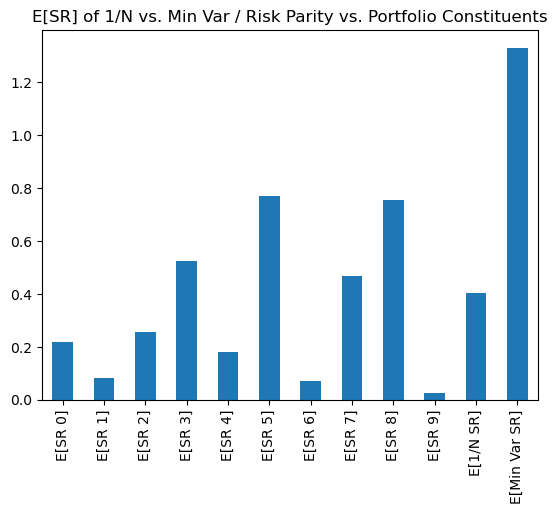

In [20]:
pd.concat(
    [
        pd.Series({f"E[SR {i}]": sr for i, sr in enumerate(expected_sharpe_ratios)}),
        pd.Series({"E[1/N SR]": expected_equal_weight_sharpe_ratio}),
        pd.Series({"E[Min Var SR]": expected_minimum_variance_sharpe_ratio}),
    ]
).plot(kind="bar", title="E[SR] of 1/N vs. Min Var / Risk Parity vs. Portfolio Constituents")